<a href="https://colab.research.google.com/github/mahdiSheykhiGithub/Transfer-Learning-on-Intel-image/blob/main/Intel_Image_EfficientNetV2B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetV2B1
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense, Flatten
from sklearn.metrics import classification_report, confusion_matrix

#Image Generator

In [ ]:
train_path = '/content/drive/MyDrive/Colab Notebooks/Intel_Image/Dataset/seg_train/seg_train'
test_path = '/content/drive/MyDrive/Colab Notebooks/Intel_Image/Dataset/seg_test/seg_test'

In [ ]:
train_generator = ImageDataGenerator(
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    zoom_range=0.1
                                    )

train_image_generator = train_generator.flow_from_directory(
                                                train_path,
                                                target_size = (150,150),
                                                batch_size = 50,
                                                class_mode = 'categorical'
                                                )

test_generator = ImageDataGenerator()
test_image_generator = test_generator.flow_from_directory(
                                                test_path,
                                                target_size = (150,150),
                                                batch_size = 50,
                                                class_mode = 'categorical'
                                                )

Found 14058 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Modeling by EfficientNetV2B1 pretrain Model

In [ ]:
pretrain_model = EfficientNetV2B1(
    include_top=False,
    weights='imagenet',
    pooling= 'max',
    input_shape = (150,150,3))

28456008/28456008 [==============================] - 0s 0us/step


In [ ]:
pretrain_model.summary()

Model: "efficientnetv2-b1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 75, 75, 32)           864       ['normalizatio

In [ ]:
set_trainable = False

for layer in pretrain_model.layers:
  if layer.name == 'block6i_project_conv':
    set_trainable = True

  layer.trainable = set_trainable

In [ ]:
model = keras.models.Sequential(name = 'EfficientNetV2B1')

model.add(pretrain_model)
model.add(Flatten(name='Flatten'))
model.add(Dense(units=128, activation='relu', name = 'fc1'))
model.add(Dropout(0.5))
model.add(Dense(units=6, activation='softmax', name = 'output'))

In [ ]:
model.summary()

Model: "EfficientNetV2B1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b1 (Functio  (None, 1280)              6931124   
 nal)                                                            
                                                                 
 Flatten (Flatten)           (None, 1280)              0         
                                                                 
 fc1 (Dense)                 (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 output (Dense)              (None, 6)                 774       
                                                                 
Total params: 7095866 (27.07 MB)
Trainable params: 634630 (2.42 MB)
Non-trainable params: 6461236 (24.65 MB)
_______

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.001)
metrics = tf.metrics.CategoricalAccuracy()
loss = tf.losses.CategoricalCrossentropy()

model.compile(optimizer = opt, loss = loss, metrics = metrics)

In [ ]:
model_history = model.fit(train_image_generator,batch_size = 50, epochs = 15, validation_data=test_image_generator, verbose = 2)

Epoch 1/15
282/282 - 3513s - loss: 0.5769 - categorical_accuracy: 0.8063 - val_loss: 0.2512 - val_categorical_accuracy: 0.9123 - 3513s/epoch - 12s/step
Epoch 2/15
282/282 - 733s - loss: 0.3531 - categorical_accuracy: 0.8752 - val_loss: 0.2075 - val_categorical_accuracy: 0.9247 - 733s/epoch - 3s/step
Epoch 3/15
282/282 - 727s - loss: 0.3131 - categorical_accuracy: 0.8904 - val_loss: 0.2209 - val_categorical_accuracy: 0.9183 - 727s/epoch - 3s/step
Epoch 4/15
282/282 - 696s - loss: 0.2845 - categorical_accuracy: 0.9031 - val_loss: 0.1800 - val_categorical_accuracy: 0.9353 - 696s/epoch - 2s/step
Epoch 5/15
282/282 - 740s - loss: 0.2600 - categorical_accuracy: 0.9088 - val_loss: 0.1924 - val_categorical_accuracy: 0.9307 - 740s/epoch - 3s/step
Epoch 6/15
282/282 - 723s - loss: 0.2497 - categorical_accuracy: 0.9124 - val_loss: 0.1785 - val_categorical_accuracy: 0.9407 - 723s/epoch - 3s/step
Epoch 7/15
282/282 - 703s - loss: 0.2425 - categorical_accuracy: 0.9145 - val_loss: 0.1989 - val_catego

# Evaluation

In [ ]:
class_name = list(test_image_generator.class_indices)
class_name

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
batch1 = test_image_generator.next()

In [ ]:
batch1[0].shape

(50, 150, 150, 3)

In [ ]:
y_prob = model.predict(batch1[0])

2/2 [==============================] - 4s 466ms/step


In [ ]:
y_pred = y_prob.argmax(axis=1)

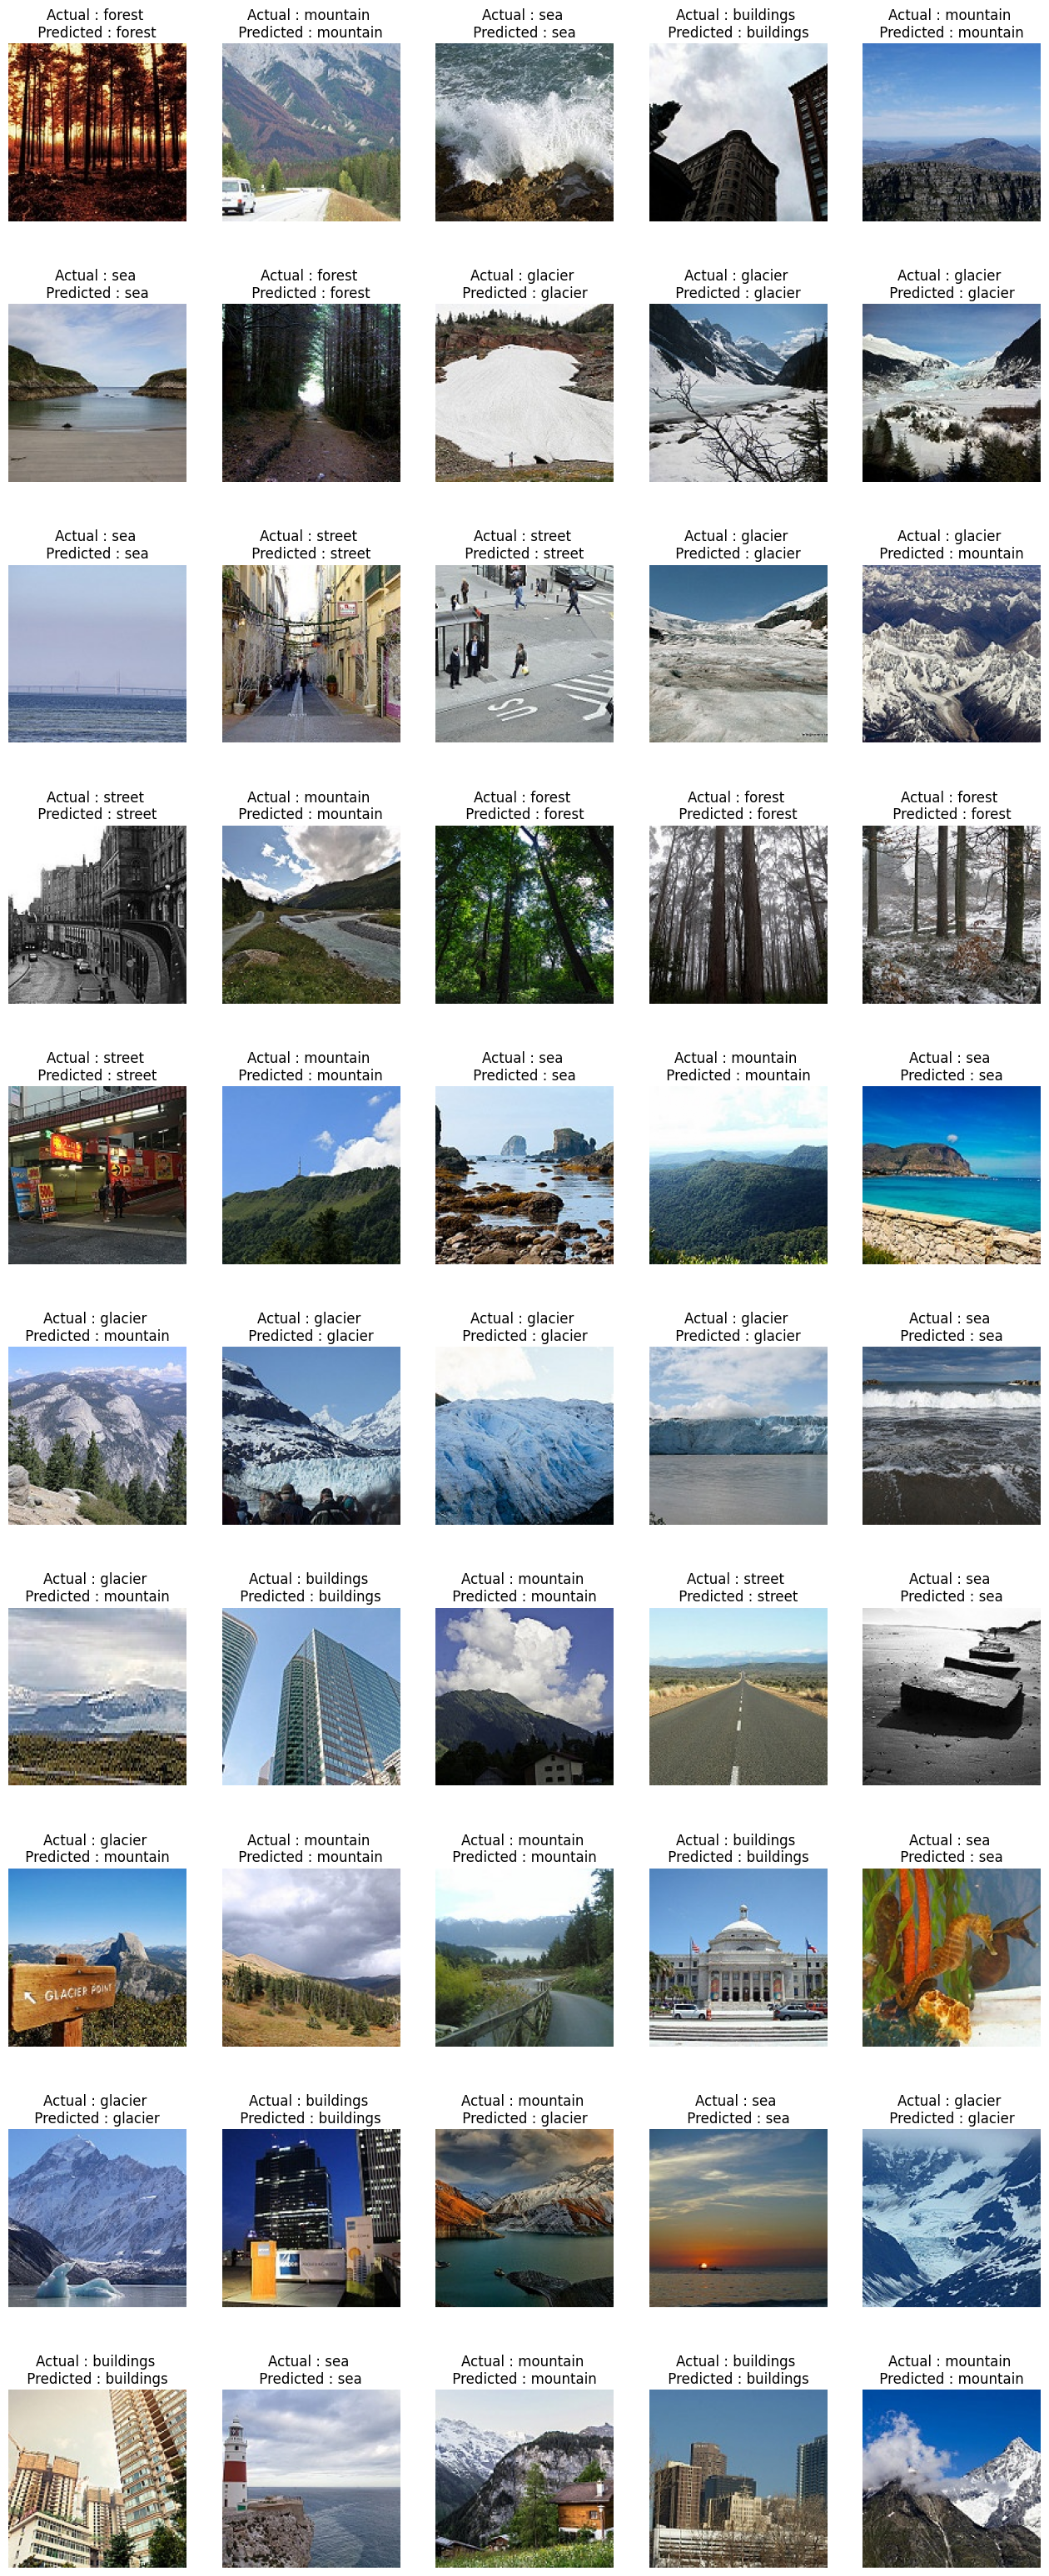

In [ ]:
plt.figure(figsize=(16,40))
for i in range(50):
  plt.subplot(10,5,i+1)
  plt.imshow(batch1[0][i]/255,cmap='Greys')
  plt.axis('off')
  plt.title("Actual : {} \n Predicted : {} ".format(class_name[batch1[1][i].argmax()],class_name[y_pred[i]]))